[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/talmolab/dreem/blob/docs/examples/dreem-demo.ipynb)

# End-to-end demo

This notebook will walk you through the DREEM pipeline end to end, from obtaining data to training a model, evaluating on a held-out dataset, and visualizing the results. Here, we use the **CLI** for training, tracking, and evaluation; an **Advanced Usage** section shows how to use configuration files for finer control.

To run this demo, we have provided sample data and configurations. The data used in this demo is small enough to be run on a CPU. 

#### Install DREEM


In [ ]:
!uv pip install dreem-track

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import yaml
import sleap_io as sio

## Download data

In [ ]:
!hf download talmolab/sample-flies --repo-type dataset --local-dir ./data

## Training

We just need to specify the data paths and the crop size to train the model. The crop size is the size (in pixels) of the square box we make around the instance. It should be of the order of the size of the instance.

Lets figure out an appropriate crop size. We can do this by loading a frame and experimenting with different sizes. For this data, a crop size of 70 seems appropriate.

In [32]:
crop_size = 70  # Adjust this to see what the bounding box looks like

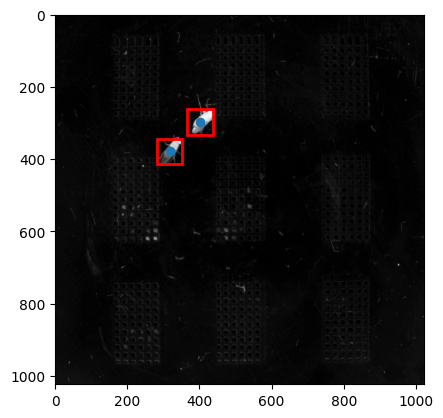

In [ ]:
slp_files = glob.glob("./data/train/*.slp")
video_files = glob.glob("./data/train/*.mp4")
labels = sio.load_slp(slp_files[0])
video = imageio.get_reader(video_files[0])
frame = video.get_data(0)
centers = []
for instance in labels[0].instances:
    centers.append(np.nanmean(instance.numpy(), axis=0))
centers = np.array(centers)
plt.imshow(frame)
plt.scatter(centers[:, 0], centers[:, 1])
# Draw a square box centered at each centroid with a given crop size (e.g., 70)
for cx, cy in centers:
    top_left = (int(cx - crop_size // 2), int(cy - crop_size // 2))
    rect = plt.Rectangle(
        top_left, crop_size, crop_size, linewidth=2, edgecolor="red", facecolor="none"
    )
    plt.gca().add_patch(rect)
plt.show()

### That's it! Now we can train the model

In [ ]:
!dreem train ./data/train --val-dir ./data/val --crop-size {crop_size}

## Tracking
Here we run tracking on a video with **no** ground truth labels using the model we just trained. Note that we're using a command line argument to set the maximum number of tracks to 2 since its a 2 flies dataset. You can run the help command below to see all the options.

In [12]:
!dreem track --help

                                                                                
 Usage: dreem track [OPTIONS] INPUT_PATH                                        
                                                                                
 Run tracking on a dataset.                                                     
                                                                                
╭─ Arguments ──────────────────────────────────────────────────────────────────╮
│ *    input_path      PATH  Input data directory [required]                   │
╰──────────────────────────────────────────────────────────────────────────────╯
╭─ Options ────────────────────────────────────────────────────────────────────╮
│ *  --checkpoint           -ckpt              PATH     Model checkpoint path  │
│                                                       [required]             │
│ *  --output               -o                 PATH     Output directory       │
│                           

In [13]:
models_dir = "./models/dreem_train"
ckpt_files = glob.glob(os.path.join(models_dir, "*final*.ckpt"))
final_ckpt = ckpt_files[0]  # Pick the first one found
print(f"Using checkpoint: {final_ckpt}")

Using checkpoint: ./models/dreem_train/epoch=0-final-val_loss=0.6908296346664429.ckpt


In [14]:
!dreem track ./data/inference --checkpoint {final_ckpt} --output ./results --crop-size {crop_size} --max-tracks 2 

Configuration saved to: results/config.track.02-04-2026-10-46-31.yaml
╭──────────────────────────── Track Configuration ─────────────────────────────╮
│ Checkpoint:  models/dreem_train/epoch=0-final-val_loss=0.6908296346664429.c… │
│ Output:      results                                                         │
│ Input:       data/inference                                                  │
╰──────────────────────────────────────────────────────────────────────────────╯
Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80/80 0:03:15 • 0:00:00 0.39it/s it/s it/s 
Saving .slp and frame metadata: 100%|██████████| 80/80 [00:00<00:00, 352.92it/s]
Results saved to results


## [Optional] Evaluate the tracking results
If you have ground truth labels, you can use `dreem eval` instead of `dreem track`. This computes tracking metrics like:
- **MOTA** (Multiple Object Tracking Accuracy)
- **IDF1** (ID F1 Score)  
- **Number of ID switches**

In [15]:
!dreem eval ./data/test --checkpoint {final_ckpt} --output "./eval-results" --crop-size {crop_size} --max-tracks 2 

Configuration saved to: eval-results/config.eval.02-04-2026-10-50-01.yaml
╭───────────────────────────── Eval Configuration ─────────────────────────────╮
│ Checkpoint:  models/dreem_train/epoch=0-final-val_loss=0.6908296346664429.c… │
│ Output:      eval-results                                                    │
│ Input:       data/test                                                       │
╰──────────────────────────────────────────────────────────────────────────────╯
Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80/80 0:03:10 • 0:00:00 0.41it/s it/s it/s 
Evaluation complete.


## And we're done!
You can take a look at the tracking metrics in the motmetrics.csv file in the directory you chose to save the results to.

## Advanced Usage
Some parameters cannot be set through CLI overrides, particularly for training. This section demonstrates the use of configuration files to achieve fine grained control over all training parameters that Pytorch Lightning offers.

#### Setup configuration file
Here we override the default training parameters to use different augmentations, minimum epochs, and optimizer parameters. You can edit these directly in the config file at the path below. Try out some of your own augmentations! We use [Albumentations](https://albumentations.ai/) for augmentations.

In [ ]:
train_config_path = "./data/configs/base.yaml"
with open(train_config_path, "r") as f:
    config_yaml = yaml.safe_load(f)
print(yaml.dump(config_yaml, default_flow_style=False))

YAML config contents:
dataset:
  train_dataset:
    anchors: centroid
    augmentations:
      GaussianBlur:
        blur_limit:
        - 3
        - 7
        p: 0.2
        sigma_limit: 0
      MotionBlur:
        blur_limit:
        - 3
        - 7
        p: 0.2
      RandomBrightnessContrast:
        brightness_limit: 0.1
        contrast_limit: 0.3
        p: 0.3
      Rotate:
        limit: 45
        p: 0.3
    clip_length: 32
    crop_size: 128
    dir:
      labels_suffix: .slp
      path: ./data/train
      vid_suffix: .mp4
    padding: 0
logging:
  logger_type: null
  name: example_train
optimizer:
  betas:
  - 0.9
  - 0.999
  eps: 1e-8
  lr: 0.0001
  name: Adam
  weight_decay: 0.01
trainer:
  max_epochs: 3
  min_epochs: 1



### Train the model with configs

In [ ]:
!dreem train ./data/train --val-dir ./data/val --crop-size {crop_size} --config ./data/configs/base.yaml

### Run inference with configs

Here we use inference overrides for more control over the tracking process. Specifically, we use max_center_dist, which limits how far each instance is allowed to be frame over frame in order to be considered the same instance, and a confidence threshold to flag low confidence predictions for manual review.

In [84]:
track_config_path = "./data/configs/inference.yaml"
with open(track_config_path, "r") as f:
    config_yaml = yaml.safe_load(f)
print(yaml.dump(config_yaml, default_flow_style=False))

ckpt_path: null
dataset:
  test_dataset:
    anchors: centroid
    clip_length: 32
    dir:
      labels_suffix: .slp
      path: ./data/inference
      vid_suffix: .mp4
outdir: ./inference
tracker:
  iou: mult
  max_center_dist: 80
  max_tracks: 2
  overlap_thresh: 0.01



In [ ]:
!dreem track ./data/inference --checkpoint {final_ckpt} --output ./results --crop-size {crop_size} --config ./data/configs/inference.yaml

## Visualize the results

**Option A – DREEM Visualizer (browser-based)**  
Download your tracking results, and head to the [live visualizer](visualizer.md) to visualize your tracking results in your browser without any data leaving your machine.

**Option B – SLEAP GUI (full pose keypoints)**  
Install SLEAP ([https://docs.sleap.ai/latest/](https://docs.sleap.ai/latest/)) and open the output `.slp` in SLEAP:
```bash
sleap-label results/<your_output_file>.slp
```
The SLEAP GUI may not render on a remote server.